# Residual Connections

[Kaiming He et al., "Deep residual layer fr image recognition", CVPR 2016](https://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html)

Given a mapping  $g : \mathbb{R}^d \to \mathbb{R}^d$, a residual connection is defined as
$$
f(x) = x + g(x).
$$

## Gradient does not vanishes

Let $f(w)=g_2(ag_1(w)+b)$ and $f_r(w)=g_1(w)+g_2(ag_1(w)+b)$.
$$
\begin{align*}
\frac{\partial f(w)}{\partial w}&=ag'_2(ag_1(w)+b)g'_1(w),\\
\frac{\partial f_r(w)}{\partial w}&=ag'_2(ag_1(w)+b)g'_1(w)+g_1'(w)=(\underbrace{ag'_2(ag_1(w)+b)+1}_{\approx 1})g'_1(w)
\end{align*}
$$

## Definition

Input
* $x \in \mathbb{R}^{d_{in}}$ 

Weights
* weight $W \in \mathbb{R}^{d_{out}\times d_{in}}$ 
* bias $b \in \mathbb{R}^{d_{out}}$

Output
* $o \in \mathbb{R}^{d_{out}}$

$$o = \text{ResConn}_{f}(x)=f(x)+\begin{cases}x,& \text{if } d_{in}=d_{out}\\
\operatorname{Linear}_{W,b}(x),& \text{if } d_{in}\neq d_{out}\\
\end{cases}.$$

where $f:\mathbb{R}^{d_{in}} \mapsto \mathbb{R}^{d_{out}}$ is the "skipped block".

## Code

In [13]:
import torch.nn as nn

class ResidualConnection(nn.Module):
    def __init__(self,block:nn.Module, in_dim:int, out_dim:int):
        super().__init__()
        self.block = block
        if in_dim != out_dim:
            self.skip = nn.Linear(in_dim, out_dim)
        else:
            self.skip = nn.Identity()

    def forward(self, x):
        return self.block(x) + self.skip(x)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activation=nn.ReLU(),res_connect:bool=False):
        super().__init__()
        layers = [nn.Flatten()]
        in_dim = input_dim
        for h_dim in hidden_dims:
            block = nn.Sequential(nn.Linear(in_dim,h_dim),
                                  nn.LayerNorm(h_dim),
                                    activation)
            if res_connect:
                layers.append(ResidualConnection(block, in_dim, h_dim))
            else:
                layers.append(block)
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, output_dim, bias=False))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

## Testing

Compare with no skip conneciton

In [14]:
import torch
import torchvision
from PIL import Image

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("mps")

### Create Dataset

In [15]:
size = (128,128)
transform = torchvision.transforms.Compose([torchvision.transforms.Resize(size),torchvision.transforms.ToTensor()])
train_dataset = torchvision.datasets.Flowers102(root='../raw_data', split = 'train', download=True, transform=transform)
test_dataset = torchvision.datasets.Flowers102(root='../raw_data', split = 'test', download=True, transform=transform)

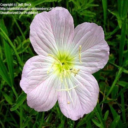

In [16]:
def visualize_image(img: torch.Tensor) -> Image.Image:
    return Image.fromarray((img.permute(1, 2, 0) * 255).to(torch.uint8).numpy())
visualize_image(train_dataset[1][0])

In [17]:
lr = 0.001
momentum = 0.9
batch_size = 32
loss = torch.nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=len(test_dataset), shuffle=False)

### Train

#### MLP

In [18]:
torch.manual_seed(1)

mlp = MLP(input_dim=size[0]*size[1]*3,
            hidden_dims=[512,512,512],
            output_dim=102
        ).to(device)


optimizer = torch.optim.SGD(mlp.parameters(), lr=lr, momentum=momentum)

mlp.train()
losses = []
for epoch in range(30):
    for img,label in train_loader:
        img = img.to(device)
        label = label.to(device)
        pred_y = mlp(img)
        optimizer.zero_grad()
        loss_value = loss(pred_y, label)
        loss_value.backward()
        optimizer.step()
        losses.append(loss_value.item())
    if epoch % 1 == 0:
        print(f"Epoch {epoch}, loss: {sum(losses)/len(losses)}")

Epoch 0, loss: 4.708431720733643
Epoch 1, loss: 4.66017971932888
Epoch 2, loss: 4.603015169501305
Epoch 3, loss: 4.5250705517828465
Epoch 4, loss: 4.438497637212277
Epoch 5, loss: 4.349057796100776
Epoch 6, loss: 4.260430756424155
Epoch 7, loss: 4.170631510205567
Epoch 8, loss: 4.083125989470217
Epoch 9, loss: 3.99211665391922
Epoch 10, loss: 3.900126477534121
Epoch 11, loss: 3.807093440865477
Epoch 12, loss: 3.7137852907180786
Epoch 13, loss: 3.621897761843034
Epoch 14, loss: 3.5301365591585636
Epoch 15, loss: 3.4344214049633592
Epoch 16, loss: 3.34289846350165
Epoch 17, loss: 3.2492192021260657
Epoch 18, loss: 3.1570728605515077
Epoch 19, loss: 3.065885372273624
Epoch 20, loss: 2.9760130057554868
Epoch 21, loss: 2.88635718610815
Epoch 22, loss: 2.7990345951655637
Epoch 23, loss: 2.711707320762798
Epoch 24, loss: 2.6288327852636577
Epoch 25, loss: 2.5465998519212008
Epoch 26, loss: 2.467034716848974
Epoch 27, loss: 2.390489754483237
Epoch 28, loss: 2.3172809724728096
Epoch 29, loss: 2

In [20]:
torch.manual_seed(1)

skipmlp = MLP(input_dim=size[0]*size[1]*3,
            hidden_dims=[512,512,512],
            output_dim=102,
            res_connect=True
        ).to(device)


optimizer = torch.optim.SGD(skipmlp.parameters(), lr=lr, momentum=momentum)

skipmlp.train()
skip_losses = []
for epoch in range(30):
    for img,label in train_loader:
        img = img.to(device)
        label = label.to(device)
        pred_y = skipmlp(img)
        optimizer.zero_grad()
        loss_value = loss(pred_y, label)
        loss_value.backward()
        optimizer.step()
        skip_losses.append(loss_value.item())
    if epoch % 1 == 0:
        print(f"Epoch {epoch}, loss: {sum(skip_losses)/len(skip_losses)}")

Epoch 0, loss: 4.865208342671394
Epoch 1, loss: 4.509928986430168
Epoch 2, loss: 4.178961778680484
Epoch 3, loss: 3.8867015428841114
Epoch 4, loss: 3.626791277527809
Epoch 5, loss: 3.384694521004955
Epoch 6, loss: 3.172346508396523
Epoch 7, loss: 2.9830534090287983
Epoch 8, loss: 2.792089663859871
Epoch 9, loss: 2.6139552032575013
Epoch 10, loss: 2.4521750250661913
Epoch 11, loss: 2.3024124652147293
Epoch 12, loss: 2.1648392425850034
Epoch 13, loss: 2.0357866200418875
Epoch 14, loss: 1.9187288030671577
Epoch 15, loss: 1.8103296800691169
Epoch 16, loss: 1.711909889435286
Epoch 17, loss: 1.6220798739620175
Epoch 18, loss: 1.5405888958086602
Epoch 19, loss: 1.4661839055363088
Epoch 20, loss: 1.3981341533224276
Epoch 21, loss: 1.336023246932944
Epoch 22, loss: 1.2791038066877618
Epoch 23, loss: 1.226780831340875
Epoch 24, loss: 1.1785464448481797
Epoch 25, loss: 1.1339434918974383
Epoch 26, loss: 1.0925765738960493
Epoch 27, loss: 1.054121986390133
Epoch 28, loss: 1.0182743565639047
Epoch 

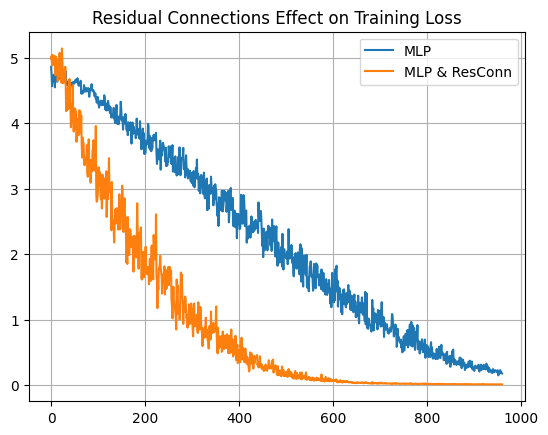

In [21]:
plt.plot(losses,linestyle="-",label="MLP")
plt.plot(skip_losses,linestyle="-",label="MLP & ResConn")
plt.title("Residual Connections Effect on Training Loss")
plt.grid(True)
plt.legend()
plt.show()

### Evaluation

In [22]:
for test_images, test_labels in test_loader:
    test_images, test_labels = test_images.to(device), test_labels.to(device)
    prred_test = mlp(test_images)
    accuracy = ((prred_test.argmax(dim=1) == test_labels).float().mean()).item()
print(f"Test accuracy: {accuracy}")

Test accuracy: 0.14587737619876862


In [23]:
for test_images, test_labels in test_loader:
    test_images, test_labels = test_images.to(device), test_labels.to(device)
    prred_test = skipmlp(test_images)
    accuracy = ((prred_test.argmax(dim=1) == test_labels).float().mean()).item()
print(f"Test accuracy: {accuracy}")

Test accuracy: 0.1527077555656433
